# Анализ рекламных источников
***

# Описание проекта

В мобильной игре пользователи реализуют космическую программу. Необходимо проанализировать рекламные источники, поведение игроков в зависимости от источника перехода, проверить зависит ли время завершения уровня от способа прохождения и иные гипотезы. Для анализа представлены данные об игроках, которые начали пользоваться приложением в период с 4 по 10 мая включительно, данные о рекламных активностях (два датасета).

В скором будущем планируется основная монетизация игры: предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

# Краткое описание данных:

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно - по игре пользователей на первом уровне.

Завершение первого уровня требует от игрока выполнения одного из двух условий:
   1. Победа над первым врагом,
   2. Реализация проекта - разработка орбитальной сборки спутников.
<br></br>

Датасет game_actions.csv - данные о событиях, совершенных в мобильной игре, ad_cost.csv - данные о расходах на источники, user_source.csv - данные о источнике привлечения пользователей.


# Ссылка на дашборд и презентацию:

https://public.tableau.com/app/profile/aleksei.petukhov/viz/sb_dashboard/sb_dash

https://github.com/ikazman/practicum_da_projects/blob/main/final_project/presentation.pdf

# Оглавление<a class='anchor' id='TOC'></a>

* **[I. Загрузка и подготовка данных](#1)**
    - [1) Импортируем библиотеки, объявим класс для анализа первичного анализа](#1_1)
    - [2) Прочитаем данные](#1_2)
    - [3) Выведем первые и последние пять строк каждой из таблиц, общую информацию](#1_3)
    - [Вывод](#1_conclusion)
* **[II. Исследовательский анализ данных](#2)**
    - [1) Профили пользователей](#2_1)
    - [2) Исследуем источники привлечения](#2_2)
    - [3) Исследование поведения пользователей](#2_3)
    - [Выводы по итогам анализа](#2_conclusion)
* **[III. Проведем статистические тесты](#3)**
    - [1) Проверим экстремальные значения](#3_1)
    - [2) Проверим распределение на нормальность](#3_2)
    - [3) Проверим гипотезу о зависимости времени завершения уровня различается в зависимости от способа прохождения](#3_3)
    - [4) Проверим гипотезу о зависимости времени завершения уровня в зависимости от числа построек](#3_4)
    - [Выводы](#3_conclusion)
<br></br>

# I. Загрузка и подготовка данных<a class='anchor' id='1'>
***

## 1) Импортируем библиотеки, объявим класс для первичного анализа<a class="anchor" id="1_1"></a>

In [1]:
import datetime
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kstest, mannwhitneyu

warnings.filterwarnings('ignore')


In [2]:
class BasicInfo:
    """Выводим базовую информацию о датасете."""

    def __init__(self):
        self.data = None

    def get_info(self):
        """Получаем базовую информацию о таблице."""

        length = len(self.data)
        # Получаем типы данных и считаем пропуски
        types = pd.DataFrame(self.data.dtypes)
        nulls = pd.DataFrame(self.data.count())

        # Объединяем типы и пропуски, переименовываем колонки
        info = pd.concat([types, nulls], axis=1).reset_index()
        info.columns = ['Column', 'Dtype', 'Non-Null Count']

        # Считаем процент пропусков
        info['% of nulls'] = (100 -
                              round(info['Non-Null Count'] / length * 100, 2))

        return info

    def get_describe(self, numeric=False):
        """Считаем описательную статистику."""
        describes = None
        # Если нет числовых значений
        if not numeric:
            describes = self.data.describe(exclude=[np.number]).fillna('---').T
            top_percent = round((describes['freq'] * 100 /
                                 describes['count']).astype(float), 2)
            describes.insert(4, '% of tops freq', top_percent)
            return describes.sort_values(by='freq')
        return describes

    def basic_info_printer(self, data):
        """Выводим первые и пооследние пять строк, 
        базовую информацию, статистику."""
        
        self.data = data

        # Получаем базовую информацию
        info = self.get_info()

        # Получаем базовую статистику
        describes = self.get_describe()

        display('Первые и последние строки', self.data,
                'Общая информация о датасете', info,
                'Описательная статистика', describes)


In [3]:
def simple_grouper(data, grouper, agg_dict={'user_id': 'nunique'}):
    """Группируем данные, считаем процентное отношение."""
    data = data.groupby(grouper).agg(agg_dict).reset_index()
    if  'user_id' in agg_dict.keys():
        data['percent'] = round(data['user_id'] * 100 / data['user_id'].sum(), 2)
        data = data.sort_values(by='user_id', ascending=False)
    return data

In [4]:
info_printer = BasicInfo()

[В оглавление](#TOC)

## 2) Прочитаем данные<a class="anchor" id="1_2"></a>

In [5]:
def reader(path):
    """Открываем файлы, присваиваем имена, добавляем в словарь, выводим отчет."""
    
    # зададим словарь со списком колонок с датами
    dates_columns = {'costs': ['day'], 
                     'actions': ['event_datetime'], 
                     'source': []}
    
    df_dict = {}
    report = pd.DataFrame(columns=['variable', 'file_name'])
    files = os.listdir(path)

    for file in files:
        if file in ['ad_costs.csv', 'game_actions.csv', 'user_source.csv']:
            file_path = path + file
            df_name = file.split('_')[1].split('.')[0]
            dates = dates_columns[df_name]
            df_dict[df_name] = pd.read_csv(file_path, parse_dates=dates)
            row_to_report = pd.DataFrame({'variable': [df_name],
                                          'file_name': [file]})
            report = pd.concat([report, row_to_report], ignore_index=True)
    print(f'Прочитано и добавлено в словарь {len(report)} файла.')
    return df_dict, report

In [6]:
datasets, report = reader('/datasets/')
report

Прочитано и добавлено в словарь 3 файла.


,variable,file_name
0,costs,ad_costs.csv
1,source,user_source.csv
2,actions,game_actions.csv


[В оглавление](#TOC)

## 3) Выведем первые пять первых и последних строк каждой из таблиц, общую информацию<a class="anchor" id="1_3"></a>

### - затраты на привлечение (ad_costs.csv)

In [7]:
info_printer.basic_info_printer(datasets['costs'])

'Первые и последние строки'

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,source,object,28,0.0
1,day,datetime64[ns],28,0.0
2,cost,float64,28,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
day,28,7,2020-05-05 00:00:00,4,14.29,2020-05-03 00:00:00,2020-05-09 00:00:00
source,28,4,youtube_channel_reklama,7,25.00,---,---


Проверим дополнительно столбец с затратами:

In [8]:
datasets['costs'].describe().T

,count,mean,std,min,25%,50%,75%,max
cost,28.0,271.556321,286.86765,23.314669,66.747365,160.056443,349.034473,969.139394


Минимально - 23.31, средняя стоимость источника - 271.56 (при медианой - 160 и 75%-процентиле равным 349). Есть очень дорогие источники.

&#9889; **Вывод:** 
1. В таблице с затратами всего 28 наблюдений об источниках покупки трафика за период от 3 мая до 9 мая,
2. Всего четрые источника - YouTube, Яндекс.Директ, Инстаграм, Фэйсбук - к каждому обращались по семь раз.
3. Нет пропусков, нет проблем с данными.
4. Потребутся дополнительно прибавить +1 день к дате перед объединением с другими таблицами.

[В оглавление](#TOC)

### - источник привлечения пользователя (user_source.csv)

In [9]:
info_printer.basic_info_printer(datasets['source'])

'Первые и последние строки'

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,user_id,object,13576,0.0
1,source,object,13576,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq
user_id,13576,13576,d27351a3-4c97-43a9-9f85-f117d60c31f8,1,0.01
source,13576,4,yandex_direct,4817,35.48


&#9889; **Вывод:** 
1. В таблице 13576 уникальных пользователей, нет пропусков и проблем с данными,
2. Больше всего пользователей пришло из Яндекса - 4817 (35.48%),
3. Нет пропусков, нет проблем с данными.

[В оглавление](#TOC)

### - события в игре (user_actions.csv)

In [10]:
info_printer.basic_info_printer(datasets['actions'])

'Первые и последние строки'

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,event_datetime,datetime64[ns],135640,0.00
1,event,object,135640,0.00
2,building_type,object,127957,5.66
3,user_id,object,135640,0.00
4,project_type,object,1866,98.62


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
event_datetime,135640,128790,2020-05-07 03:10:43,4,0.00,2020-05-04 00:00:01,2020-06-05 12:32:49
user_id,135640,13576,ff841992-d93b-462e-bc6e-18c24a514f36,22,0.02,---,---
project_type,1866,1,satellite_orbital_assembly,1866,100.00,---,---
building_type,127957,3,spaceport,59325,46.36,---,---
event,135640,3,building,127957,94.34,---,---


Проверим какие события есть в таблице:

In [11]:
datasets['actions'].event.unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

Три события - строительство, завершение первого этапа и, возможно - тут требуется уточнение, завершение проекта.

&#9889; **Вывод:** 
1. В таблице 135 639 наблюдениях о событиях в игре за период от четвертого мая до пятого июня, нет проблем с данными, но есть пропуски,
2. В столбце с типом здания (building_type) - 5.66% пропусков (7 683), в столбце с типом проекта (project_type) - 98.62% пропусков (133 774).
3. С некоторой осторожностью, природа пропусков с типом проекта, вероятно, связана со способом прохождения игры. Пропуски в типах зданий потребуют дополнительной проверки - мы не знаем, можно ли ничего не строить - но с предположу на данном этапе, что эти игроки покинули игру вначале.
4. Есть относительно более активный пользователь с 22 событями (~2%), позже, возможно, стоит взглянуть на него внимательнее.


[В оглавление](#TOC)

### - проверим полные дубликаты в данных

In [12]:
duplicated_datasets = {}
for key, dataset in datasets.items():
    duplicated_datasets[key] = (dataset.duplicated() == True).sum()
duplicated_datasets

{'costs': 0, 'source': 0, 'actions': 1}

В таблице с событиями найден 1 полный дубликат. Проверим:

In [13]:
datasets['actions'][datasets['actions'].duplicated(keep=False) == True]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


&#9889; **Вывод:** выявлен один полный дубликат, который будет удален за незначительностью.


[В оглавление](#TOC)

### - проверим последовательно ли идут события

Убедимся в том, что события представлены последовательно во времени:

In [14]:
datasets['actions']['event_datetime'].is_monotonic

True

&#9889; **Вывод:** события идут последовательно.


[В оглавление](#TOC)

### - cделаем специальные копии таблиц для анализа, внесем в копии необходиыме для анализа изменения

Сделаем специальные копии таблиц для анализа:

In [15]:
costs, source, actions = datasets.values()

В таблице с издержками прибавим дополнительный день:

In [16]:
costs['day'] = costs['day'] + datetime.timedelta(1)
costs.head(3)

,source,day,cost
0,facebook_ads,2020-05-04,935.882786
1,facebook_ads,2020-05-05,548.354480
2,facebook_ads,2020-05-06,260.185754


Исключим дубликат из таблицы actions:

In [17]:
actions.drop_duplicates(inplace=True)
actions.head(3)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN


## Вывод<a class="anchor" id="1_conclusion"></a>

1. Прочитали данные, столбы с датами приведены к нужному формату приведено к соответсвующему формату. 
2. В таблице о событиях в игре есть пропуски столбцах с типом здания (5.66%), с типом проекта (98.62%). Предполагаю, что пропуски, в обоих случаях, носят содержательный характер, нежели технический.
3. Датасеты доступны через словарь datasets по ключам costs, actions, source, а также сохранены специальные копии для анализа в переменных соответсвующим ключам.
4. В таблицу с издержками прибавили дополнительный день в столбец с датой для последющего объединения, в таблице с событиями исключили один полный дубликат.

[В оглавление](#TOC)

# II. Исследовательский анализ данных<a class='anchor' id='2'>
***

## 1) Профили пользователей<a class="anchor" id="2_1"></a>

### - дополним данные о событиях данными об источнике

In [18]:
united_data = actions.merge(source)
united_data

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,facebook_ads
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,facebook_ads
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,youtube_channel_reklama
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,youtube_channel_reklama


Переименуем источники привлечения для читабельности:

In [19]:
sources_to_rename = [costs, source, united_data]
for data in sources_to_rename:
    data.replace({'yandex_direct': 'Я.Директ',
                  'youtube_channel_reklama': 'YouTube',
                  'facebook_ads': 'Facebook',
                  'instagram_new_adverts': 'Instagram'}, inplace=True)

### - получим профили

In [20]:
def get_profiles(data, costs):
    """Cоздаем пользовательские профили."""

    # Находим параметры первых посещений
    profiles = (data
                .sort_values(by=['user_id', 'event_datetime'])
                .groupby('user_id').agg({'event_datetime': 'first',
                                         'event': 'first',
                                         'building_type': 'first',
                                         'project_type': 'first',
                                         'source': 'first'})
                .rename(columns={'event_datetime': 'first_ts'})
                .reset_index())

    # Для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['day'] = pd.to_datetime(profiles['first_ts']).dt.date
    # profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # посчитаем сколько зданий построил каждый игрок
    buildings_num = (data.groupby('user_id').agg({'building_type': 'nunique'})
                                            .rename(columns={'building_type': 'num_of_builds'})
                                            .reset_index())
    profiles = profiles.merge(buildings_num)

    # Добавим в профиль сведения о последнем событии для каждого пользователя
    last_event = (data.groupby(['user_id', 'event_datetime'])
                  .last()
                  .reset_index()
                  .drop_duplicates(subset=['user_id'], keep='last')
                  [['user_id', 'event', 'event_datetime']])
    last_event.columns = ['user_id', 'last_event', 'last_ts']
    profiles = profiles.merge(last_event)

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (profiles.groupby(['day', 'source']).agg({'user_id': 'nunique'})
                 .rename(columns={'user_id': 'unique_users'})
                 .reset_index())
    new_users['day'] = pd.to_datetime(new_users['day']).dt.date

    # объединяем траты на рекламу и число привлечённых пользователей
    costs['day'] = pd.to_datetime(costs['day']).dt.date
    ad_costs = costs.merge(new_users, on=['day', 'source'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = (
        ad_costs['cost'] / ad_costs['unique_users'])

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['day', 'source', 'acquisition_cost']],
        on=['day', 'source'],
        how='left')
    
    # заполняем пропуски
    profiles = profiles.fillna('None')
    
    #избавимся от столбца с днем за отсутвием необходимости
    profiles.drop(columns='day', inplace=True)
    
    #посчитаем время, проведенное в игре в часах
    profiles['hours_in_game'] = round((profiles['last_ts'] - profiles['first_ts']).dt.total_seconds() / 3600, 2)
    
    #переименуем столбец с building_type в first_building_type
    profiles.rename(columns={'building_type': 'first_building_type'}, inplace=True)
    
    #определим порядок столбцов
    columns_order = ['user_id', 'first_ts',
                     'first_building_type', 'last_ts', 'last_event', 
                     'hours_in_game', 'project_type', 'num_of_builds',
                     'source', 'acquisition_cost']


    return profiles[columns_order]


In [21]:
profiles = get_profiles(united_data, costs)
info_printer.basic_info_printer(profiles)

'Первые и последние строки'

,user_id,first_ts,first_building_type,last_ts,last_event,hours_in_game,project_type,num_of_builds,source,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,assembly_shop,2020-05-20 11:26:06,building,346.31,None,3,Facebook,0.754162
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,assembly_shop,2020-05-18 10:46:52,building,295.63,None,2,Я.Директ,0.464206
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,assembly_shop,2020-05-14 09:21:27,building,207.21,None,2,YouTube,0.390759
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,assembly_shop,2020-05-12 07:40:47,finished_stage_1,154.65,None,2,Instagram,0.631816
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,assembly_shop,2020-05-22 02:46:45,building,396.95,None,3,Facebook,0.790136
...,...,...,...,...,...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,assembly_shop,2020-05-11 22:15:54,finished_stage_1,188.28,None,3,Instagram,0.649590
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,2020-05-04 11:58:14,assembly_shop,2020-05-14 10:11:36,building,238.22,None,3,Facebook,0.790442
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04 02:05:09,assembly_shop,2020-05-12 13:01:52,finished_stage_1,202.95,None,3,Я.Директ,0.466381
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,2020-05-04 20:28:28,assembly_shop,2020-05-11 22:04:30,building,169.60,None,2,Instagram,0.649590


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,user_id,object,13576,0.0
1,first_ts,datetime64[ns],13576,0.0
2,first_building_type,object,13576,0.0
3,last_ts,datetime64[ns],13576,0.0
4,last_event,object,13576,0.0
5,hours_in_game,float64,13576,0.0
6,project_type,object,13576,0.0
7,num_of_builds,int64,13576,0.0
8,source,object,13576,0.0
9,acquisition_cost,float64,13576,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
user_id,13576,13576,d27351a3-4c97-43a9-9f85-f117d60c31f8,1,0.01,---,---
last_ts,13576,13507,2020-05-13 23:12:58,2,0.01,2020-05-04 01:53:12,2020-06-05 12:32:49
first_ts,13576,13304,2020-05-04 04:02:30,4,0.03,2020-05-04 00:00:01,2020-05-10 23:59:52
source,13576,4,Я.Директ,4817,35.48,---,---
last_event,13576,2,building,7759,57.15,---,---
project_type,13576,2,None,11710,86.26,---,---
first_building_type,13576,1,assembly_shop,13576,100.00,---,---


&#9889; **Вывод:** собрали профили пользователей, размер полученной таблице соответсnвует колиечству уникальных пользователей. Уже сейчас можно сделать выводы о самом привлекаеющем источнике, результатах игроков. Посмотрим внимательнее.

[В оглавление](#TOC)

## 2) Исследуем источники привлечения<a class="anchor" id="2_2"></a>

### - проверим соотношение источников привлечения в полученных профилях

In [22]:
simple_grouper(profiles, 'source')

,source,user_id,percent
3,Я.Директ,4817,35.48
1,Instagram,3347,24.65
0,Facebook,2726,20.08
2,YouTube,2686,19.78


&#9889; **Вывод:** в представленных данных относительно больше привлекает Яндекс.Директ - 4817 (35.48%), далее идут сравнительно ровно Инстаграм - 2 575 (24.65%), Фэйсбук - 2 726 (20.08%), YouTube - 2 686 (19.78%).

[В оглавление](#TOC)

### - визуализируем соотношение источников покупки трафика

Для визуализации используем круговую диаграмму, по центру которой выведем источник с самым большим числом привлеченных: пригодится для презентации.

In [23]:
def pie_chart_categories(df, column, desc=''):
    """Круговая диаграмма."""
    
    # Подготовим данные для визуализации,
    # посчитаем проценты
    data = df.copy()
    data = pd.DataFrame(data[column].value_counts())
    data['percent'] = (data[column] /
                       sum(data[column])) * 100
    
    # Отбросим значния менее 1%
    data = data[data['percent'] > 1]
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 8))

    # Нарисуем основную диаграмму
    plt.pie(data['percent'].values, labels=data.index,
                 autopct='%0.2f%%', pctdistance=0.7)
  
    # Добавим круг по центру
    centre_circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Выбрем тип заведения с самым большой долей
    max_percent = data['percent'].max()
    type_with_max_percent = data.loc[data['percent']
                                     == data['percent'].max()].index[0]
    
    # Добавим сообщение в круг
    message_in_circle = f'{type_with_max_percent} \n  {max_percent:.2f} %'
    plt.text(0, 0, message_in_circle, fontsize=32, ha='center', va='center')

    # Добавим заголовок, источник данных
    plt.title(desc, loc='left', fontsize=13, fontweight='bold')
    source = "Источник: компания «Космические братья»"
    plt.text(-1, -1.2, source, color='#a2a2a2', fontsize=10)

    plt.tight_layout()
    plt.axis('square')


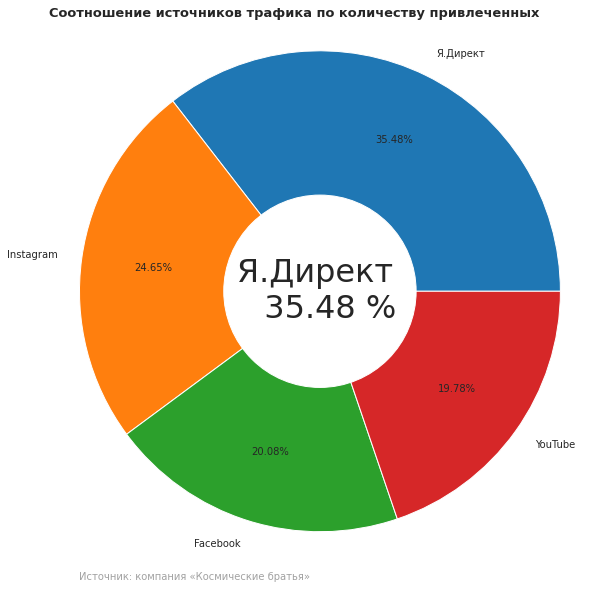

In [24]:
pie_chart_categories(profiles, 'source', 'Cоотношение источников трафика по количеству привлеченных')

### - оценим расходы на привлечение пользователей

In [25]:
channels_by_user = simple_grouper(united_data, 'source').rename(columns={'source': 'канал',
                                                                         'user_id': 'число игроков',
                                                                         'percent': '% от игроков'})

# посчитаем сколько раз обращались к каждому источнику
applied_to_channel = (costs.groupby('source')
                           .agg({'day': 'count'})
                           .reset_index()
                           .rename(columns={'source': 'канал', 'day': 'дней закупки трафика'}))

# посчитаем отдельно среднюю стоимость привлечения клиента по источнику, чтобы потом не избавляться от мультиндекса
channels_acquisition_costs = (profiles.groupby('source')
                               .agg({'acquisition_cost': 'mean'})
                               .reset_index()
                               .rename(columns={'source': 'канал',
                                                'acquisition_cost': 'затраты на привлечение'}))

# посчитаем затраченную на каждый из каналов сумму и % от бюджета
channels_costs = (profiles.groupby('source')
                          .agg({'acquisition_cost': 'sum'})
                          .reset_index()
                          .sort_values(by='acquisition_cost'))
channels_costs['% от рекламного бюджета'] = (channels_costs['acquisition_cost'] * 100 / 
                                             sum(channels_costs['acquisition_cost']))
channels_costs = channels_costs.rename(columns={'source': 'канал',
                                                'acquisition_cost': 'сумма трат'})

# объединим таблицу с затратами с таблицей обращений и числом привлеченных
channels_costs = channels_costs.merge(channels_by_user, on='канал')
channels_costs = channels_costs.merge(channels_acquisition_costs, on='канал')
channels_costs = channels_costs.merge(applied_to_channel, on='канал')

# дополним таблицу суммирующую строку
sums_row = pd.Series(['---', sum(channels_costs['сумма трат']),
                      sum(channels_costs['% от рекламного бюджета']),
                      sum(channels_costs['число игроков']),
                      sum(channels_costs['% от игроков']),
                      channels_costs['затраты на привлечение'].mean(),
                      sum(channels_costs['дней закупки трафика'])],
                      index=channels_costs.columns)
channels_costs = channels_costs.sort_values(by='сумма трат')
channels_costs = channels_costs.append(sums_row, ignore_index=True)

channels_costs

,канал,сумма трат,% от рекламного бюджета,число игроков,% от игроков,затраты на привлечение,дней закупки трафика
0,YouTube,1068.119204,14.047588,2686,19.78,0.397662,7
1,Facebook,2140.904643,28.156546,2726,20.08,0.785365,7
2,Instagram,2161.441691,28.426643,3347,24.65,0.645785,7
3,Я.Директ,2233.111449,29.369223,4817,35.48,0.463590,7
4,---,7603.576987,100.000000,13576,99.99,0.573100,28


&#9889; **Вывод:**

- у каждому из рекламных источников закупали трафик 7 дней,
- самое раннее наблюдение о понесенных расходах - 03.05.2020 года, самое позднее - 09.05.2020 года,
- за период от 01.05.2019 до 27.10.2019 года потратили 7 603.57 долларов,
- Яндекс.Директ (29.36), Инстаграм (28.42) и Фэйсбук (28.15) получили примерно 28-29% от рекламного бюджета, YouTube вдвое меньше - 14%.
- самая высокая стоимость привлечения у Фэйсбук - 0.79 долларов, на втором месте Инстаграм - 0.65 долларов, на третьем месте Яндекс.Директ - 0.46 долларов, дешевле всего YouTube - 0.4 долларов.
- средняя стоимость привлечения одного пользователя - 0.57 долларов.
- Фэйсбук как канал привлечения выглядит сравнительно неэффективным, привлечение практически идентично YouTube (20.08% и 19.78%, соответственно), но стоимость привлечения вдвое больше (0.79 против 0.4, соответственно).


[В оглавление](#TOC)

## 3) Исследование поведения пользователей<a class="anchor" id="2_3"></a>

### - выясним, сколько пользователей завершило первый этап

In [26]:
simple_grouper(profiles, 'last_event')

,last_event,user_id,percent
0,building,7759,57.15
1,finished_stage_1,5817,42.85


&#9889; **Вывод:** менее половины пользователей (42.85%) завершило первый этап на момент выгрузки данных.


[В оглавление](#TOC)

### - проверим сколько пользователей завершило первый этап в зависимости от источника (от общего числа пользователей)

In [27]:
finished_by_source = (profiles.groupby(['source', 'last_event'])
                              .agg({'user_id': 'count'})
                              .reset_index()
                              .query('last_event == "finished_stage_1"'))
finished_by_source['percent'] = round(finished_by_source['user_id'] * 100 / len(profiles), 2)
finished_by_source.sort_values(by='percent', ascending=False, inplace=True)
finished_by_source

,source,last_event,user_id,percent
7,Я.Директ,finished_stage_1,2042,15.04
3,Instagram,finished_stage_1,1466,10.80
5,YouTube,finished_stage_1,1159,8.54
1,Facebook,finished_stage_1,1150,8.47


Визуализируем процент завершивших первый этап в зависимости от источника.

In [28]:
def percent_bar(data, column, labels=None):
    """Столбчатый график для визуализации процентного соотношения."""

    # если не переданы подписи
    if not labels:
        labels = {'bar_label': '', 
                  'xlabel': '', 
                  'ylabel': '',
                  'title': '',
                  'source': ''}

    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 7))

    # зададим ширину столбца
    bar_width = 0.85

    # рисуем столбчатый график
    plt.bar(data[column], 
            data['percent'], 
            color='#076fa2', 
            edgecolor='white',
            width=bar_width,
            label=labels['bar_label'] if labels else '')

    # подпишем проценты над столбцами
    for object_type, point in zip(data[column],
                                  data['percent'].values):
        plt.text(object_type, point + 5.5, f'{point}%', ha='center', va='top')

    # второй столбчатый график белого цвета
    plt.bar(data[column], 
            100 - data['percent'], # высота столбца
            bottom=data['percent'], # нулевая точка
            color='white',
            edgecolor='white',
            alpha=0,
            width=bar_width)

    # повернем засечки, подпишем оси
    plt.xticks(rotation=45, ha="right")

    # добавим легкие горизонтальные линии
    plt.grid(axis='y', alpha=0.15)
    plt.grid(axis='x', alpha=0)

    # спрячем лишние границы
    sns.despine(left=True, bottom=True)
    
    # подпишем график, добавим источник, выведем легенду,
    plt.xlabel(labels['xlabel'], labelpad=30)
    plt.ylabel(labels['ylabel'])
    plt.title(labels['title'], loc='left', pad=30,
              fontsize=12, fontweight='bold')
    source = 'Источник: ' + labels['source'] 
    plt.text(-0.5, -35, source, color='#a2a2a2', fontsize=10)
    plt.legend(loc=0)


In [29]:
labels = {'bar_label': 'Источник привлечения', 
          'xlabel': 'Источник привлечения', 
          'ylabel': 'Проценты',
          'title': 'Процент завершивших от всех игроков первый этап в зависимости от источника',
          'source': 'компания «Космические братья»'}

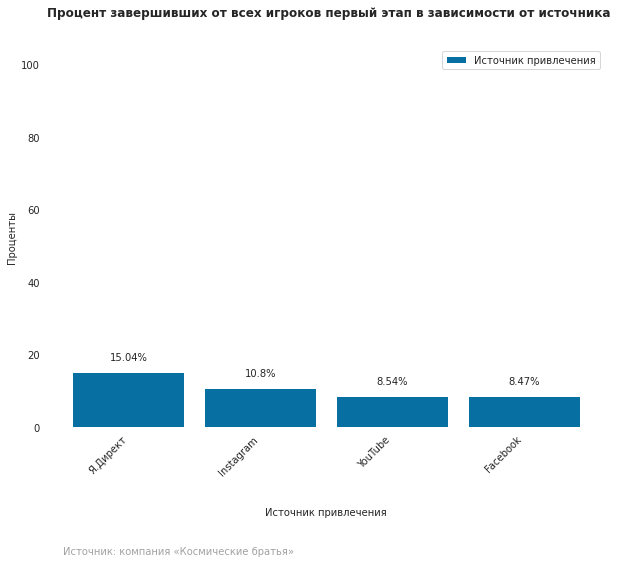

In [30]:
percent_bar(finished_by_source, 'source', labels=labels)

&#9889; **Вывод:** в представленных данных первый этап завершили пользователи от общего чила пользователей:
- 15.04% из Я.Директ,
- 10.8% из Instagram,
- 8.54% из YouTube,
- 8.47% из Facebook.


[В оглавление](#TOC)

### - проверим сколько пользователей завершило первый этап путем реализации проекта

Для начала убедимся, что число наблюдений с событием "project" и типом проекта в основном датасете совпадает и они все пересекаются:

In [31]:
project_event = datasets['actions'].query('event == "project"')
project_type = datasets['actions'].query('project_type == "satellite_orbital_assembly"')

In [32]:
len(list(np.intersect1d(project_event['user_id'], project_type['user_id'])))

1866

In [33]:
print(len(project_event), len(project_type))

1866 1866


Число наблюдений совпадает и они все пересекаются, так что можем сделать, с некоторой осторожностью, можно предположить, что данные наблюдения свидетельствует о завершении игроком проекта. Проверим сколько игроков завершили первый этап путем проекта:

In [34]:
simple_grouper(profiles, 'project_type')

,project_type,user_id,percent
0,None,11710,86.26
1,satellite_orbital_assembly,1866,13.74


In [35]:
def source_project():
    merging_result = pd.DataFrame()
    for source in profiles.source.unique():
        source_query = (simple_grouper(profiles.query(f'source == "{source}"'),
                                       ['source', 'project_type'])
                        .sort_values(by='source'))
        merging_result = pd.concat([merging_result, source_query])

    return merging_result.query('project_type == "satellite_orbital_assembly"')

In [36]:
project_by_source = source_project()
project_by_source

,source,project_type,user_id,percent
1,Facebook,satellite_orbital_assembly,391,14.34
1,Я.Директ,satellite_orbital_assembly,620,12.87
1,YouTube,satellite_orbital_assembly,379,14.11
1,Instagram,satellite_orbital_assembly,476,14.22


In [37]:
labels = {'bar_label': 'Источник привлечения', 
          'xlabel': 'Источник привлечения', 
          'ylabel': 'Проценты',
          'title': 'Стратегия пользователей в зависимости от источника привлечения',
          'source': 'компания «Космические братья»'}

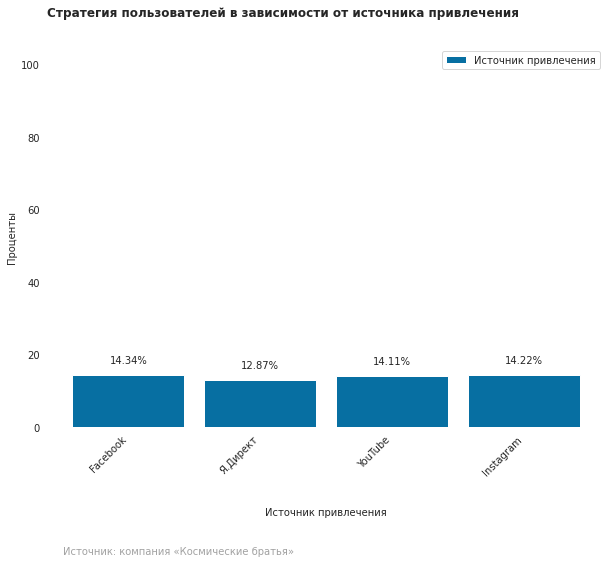

In [38]:
percent_bar(project_by_source, 'source', labels=labels)

&#9889; **Вывод:** только 13.74% выбрало способ завершения первого этапа через проект.


### - проверим сколько зданий строят игроки

In [39]:
num_of_builds = simple_grouper(profiles, 'num_of_builds')
num_of_builds

,num_of_builds,user_id,percent
2,3,7671,56.50
1,2,5560,40.95
0,1,345,2.54


&#9889; **Вывод:** подавляющее большинство игроков построили более двух зданий - 97.45%, одним зданием ограничилось только 2.54%.

[В оглавление](#TOC)

### - проверим сколько зданий строят игроки в зависимости от источника привлечения

Для прихотливого расчета процентов игроков подготовим функцию, дополняющую simple_grouper:

In [40]:
def source_builders():
    merging_result = pd.DataFrame()
    for source in profiles.source.unique():
        source_query = (simple_grouper(profiles.query(f'source == "{source}"'),
                                       ['source', 'num_of_builds'])
                        .sort_values(by='source'))
        merging_result = pd.concat([merging_result, source_query])

    return merging_result

In [41]:
builds_by_source = source_builders()
builds_by_source

,source,num_of_builds,user_id,percent
2,Facebook,3,1577,57.85
1,Facebook,2,1087,39.88
0,Facebook,1,62,2.27
2,Я.Директ,3,2710,56.26
1,Я.Директ,2,1990,41.31
0,Я.Директ,1,117,2.43
2,YouTube,3,1478,55.03
1,YouTube,2,1121,41.73
0,YouTube,1,87,3.24
2,Instagram,3,1906,56.95


In [42]:
def sns_catplot(data, x='', y='', hue='', labels=None):
    """Столбчатый график для визуализации категорий."""
    
    sns.set(style='whitegrid')
    sns.catplot(x=x, y=y, hue=hue, 
                kind='bar', errwidth=0,
                data=data, height=5, aspect=3, legend=False, hue_order=[3, 2, 1])
    
    # добавим легкие горизонтальные линии
    plt.grid(axis='y', alpha=0.15)
    plt.grid(axis='x', alpha=0)

    # спрячем лишние границы
    sns.despine(left=True, bottom=True)
    
    # подпишем график, добавим источник, выведем легенду,
    plt.xlabel(labels['xlabel'], labelpad=30)
    plt.ylabel(labels['ylabel'])
    plt.title(labels['title'], loc='left', pad=30,
              fontsize=12, fontweight='bold')
    source = 'Источник: ' + labels['source'] 
    plt.text(-0.5, -15, source, color='#a2a2a2', fontsize=10)
    plt.legend(loc=0)


In [43]:
labels = {'bar_label': 'Источник привлечения', 
          'xlabel': 'Источник привлечения', 
          'ylabel': 'Проценты',
          'title': 'Процент числа построек в зависимости от источника привлечения',
          'source': 'компания «Космические братья»'}

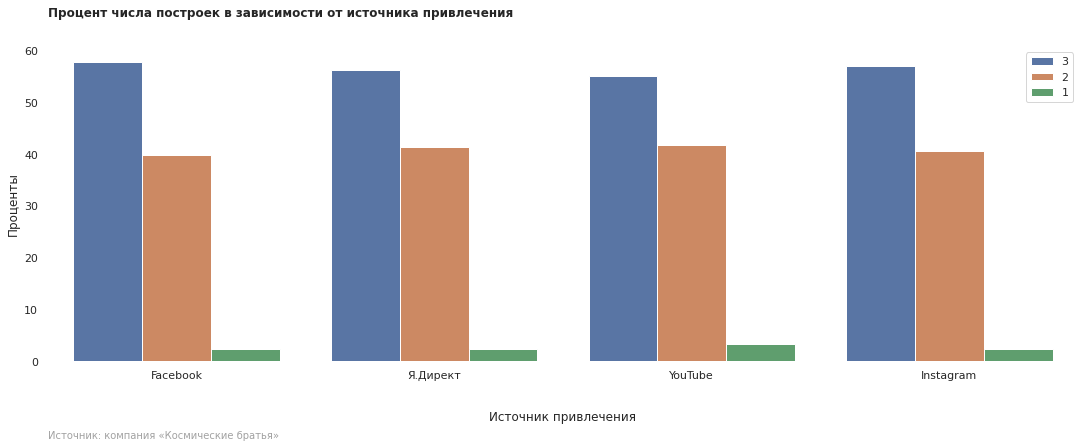

In [44]:
sns_catplot(builds_by_source, x='source', y='percent', hue='num_of_builds', labels=labels)

&#9889; **Вывод:** источник привлечения не влияет на количество зданий, которые строят игроки.

### - проверим сколько пользователей завершают уровень в зависимости от количества зданий

In [45]:
finished_and_builds = simple_grouper(profiles.query('last_event == "finished_stage_1"'), 'num_of_builds')
finished_and_builds['percent_in_group'] = round(finished_and_builds.user_id * 100 / num_of_builds.user_id, 2)
finished_and_builds

,num_of_builds,user_id,percent,percent_in_group
2,3,4208,72.34,54.86
1,2,1552,26.68,27.91
0,1,57,0.98,16.52


&#9889; **Вывод:** усматривается связь между количество построенных зданий и завершением первого этапа. Первый этап завершили:
- 54.86% игроков с тремя зданиями,
- 27.91% игроков с двумя зданиями,
- 16.52% игроков с одним зданием.

[В оглавление](#TOC)

### - выясним какие здания есть у всех пользователей, а какие пользуются меньшей популярностью

In [46]:
building_types = simple_grouper(actions, 'building_type')
building_types['percent_of_users'] = round(building_types.user_id * 100 / len(profiles.user_id), 2)
building_types

,building_type,user_id,percent,percent_of_users
0,assembly_shop,13576,39.38,100.00
2,spaceport,13231,38.38,97.46
1,research_center,7671,22.25,56.50


&#9889; **Вывод:** 

Здания распределены неравномерно:
- сборочный цех (assembly_shop) - есть у всех пользователей, это здание составляет примерно 39% от всех построек.
- космический порт (spaceport) - есть у 97.46% пользователей, это здание составляет примерно 38% от всех построек.
- исследовательский центр (research_center) построило только чуть больше половины игроков - 56.50%, это здание составляет примерно 22.25% от всех построек.

[В оглавление](#TOC)

### - выясним сколько пользователи проводят времени в игре

In [47]:
profiles[['hours_in_game']].describe().T

,count,mean,std,min,25%,50%,75%,max
hours_in_game,13576.0,256.218791,104.411245,0.0,184.56,252.515,319.485,741.98


&#9889; **Вывод:** 

- среднее время в игре - 256 часов (или 10 дней),
- минимальное время в игре - менее часа, макисмальное - 741 час (почти 31 день), 75% всех игроков проводят в игре 319 часов (13 дней),
- учитывая, что среднее и медиана почти совпадают, выбросов нет.

[В оглавление](#TOC)

### - проверим как влияет источник привлечения на среднее время в игре

In [48]:
simple_grouper(profiles, 'source', agg_dict={'hours_in_game': 'mean'})

,source,hours_in_game
0,Facebook,257.555216
1,Instagram,258.922593
2,YouTube,254.084456
3,Я.Директ,254.773930


&#9889; **Вывод:**  близкие значения, с некоторой осторожностью можно сделать вывод о том, что источник привлечения не оказывает существенного влияния на время в игре.

[В оглавление](#TOC)

### - проверим влияет ли число построек на время проведенное в игре

Построим диаграмму размаха по времени в игре относительно числа построек

In [49]:
def boxplotter(data, columns, labels=None):
    """Диаграмма размаха."""
    
    # если не переданы подписи
    if not labels:
        labels = {'xlabel': '', 
                  'ylabel': '',
                  'title': '',
                  'source': ''}
        
    x_col, y_col = columns

    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 10))

    sns.boxplot(x=x_col, y=y_col, data=data)
    sns.despine(left=True, bottom=True)
    # подпишем график, добавим источник
    plt.xticks(ha="right")
    plt.xlabel(labels['xlabel'], labelpad=15)
    plt.ylabel(labels['ylabel'])
    plt.title(labels['title'], loc='left', pad=15,
              fontsize=12, fontweight='bold')
    source = 'Источник: ' + labels['source'] 
    plt.text(-0.55, -125, source, color='#a2a2a2', fontsize=10)
    plt.tight_layout()


In [50]:
labels = {'xlabel': 'Число построек', 
          'ylabel': 'Время в игре',
          'title': 'Диаграмма размаха: время в игре в зависимости от числа построек',
          'source': 'компания «Космические братья»'}

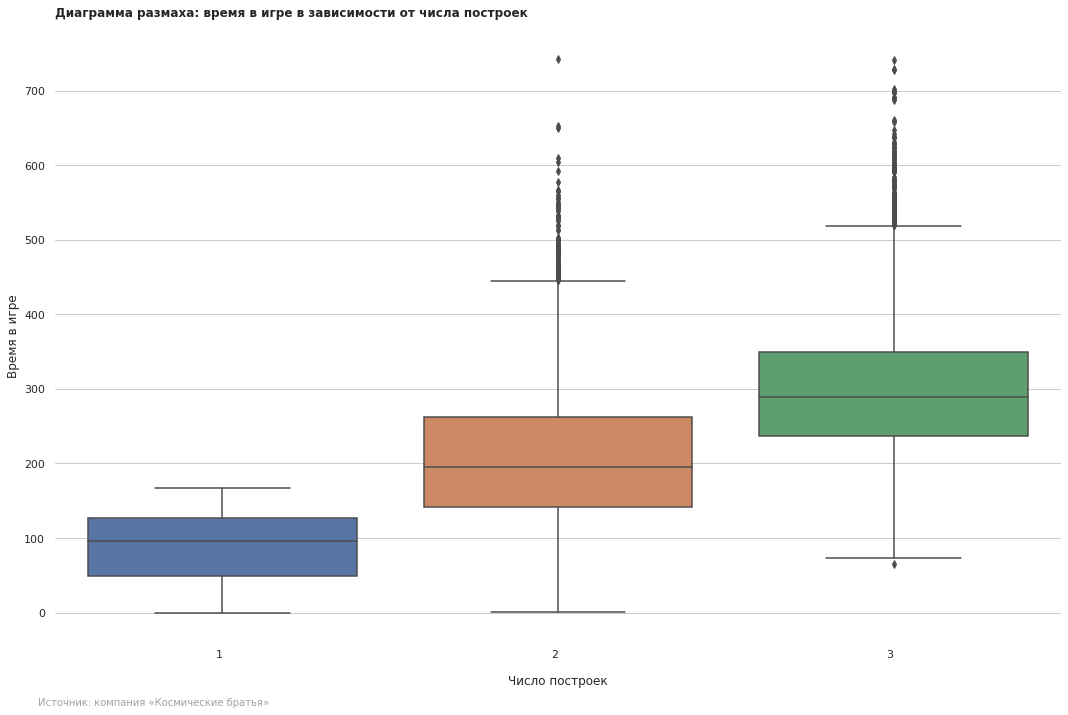

In [51]:
boxplotter(profiles, ['num_of_builds', 'hours_in_game'], labels)

Время в игре существенно различается в зависимости от количества построек. Посчитаем среднее время в игре:

In [52]:
simple_grouper(profiles, 'num_of_builds', agg_dict={'hours_in_game': 'mean'})

,num_of_builds,hours_in_game
0,1,85.476290
1,2,206.829165
2,3,299.695845


&#9889; **Вывод:** как было выявлено ранее, игроки завершают первый уровень независимо от количества построек - есть игроки и с одним зданием, однако из представленных данных следует, что количество построек сильно влияет на время в игре.



[В оглавление](#TOC)

### - проверим как время в игре зависит от выполения проекта

In [53]:
simple_grouper(profiles, 'project_type', agg_dict={'hours_in_game': 'mean'})

,project_type,hours_in_game
0,None,245.574965
1,satellite_orbital_assembly,323.013650


&#9889; **Вывод:** среднее время в игре при выполнении проекта в среднем выше на 77 часов (3 дня).

[В оглавление](#TOC)

## Выводы по итогам анализа<a class="anchor" id="2_conclusion"></a>

**В отношении источников привлечения пользователей по итогам анализа усматривается следующее**:

1. Исходя из представленных данны, относительно больше трафика за семь дней закупки привлек Яндекс.Директ - 4817 (35.48%), далее идут сравнительно ровно Инстаграм - 2 575 (24.65%), Фэйсбук - 2 726 (20.08%), YouTube - 2 686 (19.78%).
2. Самое раннее наблюдение о понесенных расходах - 03.05.2020 года, самое позднее - 09.05.2020 года (для целей анализа дату сдвинули на один день вперед), всего за сем дней потратили на покупку трафика 7 603.57 долларов.
3. Яндекс.Директ (29.36), Инстаграм (28.42) и Фэйсбук (28.15) получили примерно 28-29% от рекламного бюджета, YouTube вдвое меньше - 14%.
4. Самая высокая стоимость привлечения у Фэйсбук - 0.79 долларов, на втором месте Инстаграм - 0.65 долларов, на третьем месте Яндекс.Директ - 0.46 долларов, дешевле всего YouTube - 0.4 долларов. 
5. Средняя стоимость привлечения одного пользователя - 0.57 долларов.
6. Фэйсбук как канал привлечения выглядит сравнительно неэффективным, привлечение практически идентично YouTube (20.08% и 19.78%, соответственно), но стоимость привлечения вдвое больше (0.79 против 0.4, соответственно).

**В отношении взаимодействия пользователей с игрой по итогам анализа усматривается следующее**:

1. Менее половины пользователей (42.85%) завершило первый этап на момент выгрузки данных: 
    - 15.04% из Я.Директ,
    - 10.8% из Instagram,
    - 8.54% из YouTube,
    - 8.47% из Facebook.
2. Источник привлечения не влияет на количество зданий, которые строят игроки, сам по себе источник привлечения не оказывает существенного влияния на время в игре.
3. Только 13.74% выбрало способ завершения первого этапа через проект. Среднее время в игре при выполнении проекта выше на 77 часов (3 дня).
4. Подавляющее большинство игроков построили более двух зданий - 97.45%, одним зданием ограничилось только 2.54%.
5. Усматривается связь между количество построенных зданий и завершением первого этапа. Первый этап завершили:
    - 54.86% игроков с тремя зданиями,
    - 27.91% игроков с двумя зданиями,
    - 16.52% игроков с одним зданием.
6. Здания распределены неравномерно:
    - сборочный цех (assembly_shop) - есть у всех пользователей, это здание составляет примерно 39% от всех построек.
    - космический порт (spaceport) - есть у 97.46% пользователей, это здание составляет примерно 38% от всех построек.
    - исследовательский центр (research_center) построило только чуть больше половины игроков - 56.50%, это здание составляет примерно 22.25% от всех построек.
7. Игроки завершают первый уровень независимо от количества построек - есть игроки и с одним зданием, однако из представленных данных следует, что количество построек сильно влияет на время в игре. Исходя из данного обстоятельства будет проверена гипотеза о влиянии количества построек на время в игре у пользователей без проекта.
8. Среднее время в игре - 256 часов (или 10 дней), минимальное время в игре - менее часа, макисмальное - 741 час (почти 31 день), 75% всех игроков проводят в игре 319 часов (13 дней).



[В оглавление](#TOC)

# III. Проведем статистические тесты<a class='anchor' id='3'>
***

## 1) Проверим экстремальные значения<a class='anchor' id='3_1'>

### - проверим статистику времени в игре

In [54]:
profiles[['hours_in_game']].describe(percentiles=[.01, .25, .5, .95, .99, 1]).T

,count,mean,std,min,1%,25%,50%,95%,99%,100%,max
hours_in_game,13576.0,256.218791,104.411245,0.0,32.7325,184.56,252.515,438.9475,530.6125,741.98,741.98


&#9889; **Вывод:** 

- время 99% всех пользователей уложилось в диапазаон от 33 часов до 530 часов (22 дня),
- минимальное значение - 0 часов, максимальное - 742 часа (31 день), которые уравновесили друг друга, за счет чего значения медианы и среднего оказались близки,
- перед статистическими тестами избавимся от экстремальных значений.

[В оглавление](#TOC)

### - выберем пользователей с нулем часов в игре

Отберем пользователей с нулем часов в игре и посчитаем их число:

In [55]:
zero_hours = profiles.query('hours_in_game == 0')
len(zero_hours)

57

Убедимся, что среди таких игроков нет завершивших первый этап:

In [56]:
sum(zero_hours.last_event == 'finished_stage_1')

0

In [57]:
zero_hours.head()

,user_id,first_ts,first_building_type,last_ts,last_event,hours_in_game,project_type,num_of_builds,source,acquisition_cost
56,011e8846-9204-434b-809a-398310d730da,2020-05-04 18:21:20,assembly_shop,2020-05-04 18:21:20,building,0.0,None,1,Instagram,0.649590
229,040813c5-ef43-49d0-bbb7-13c532efe6bc,2020-05-06 04:54:51,assembly_shop,2020-05-06 04:54:51,building,0.0,None,1,Я.Директ,0.464206
378,06d035a3-f3f0-4f3a-ae54-e4a7a33c1409,2020-05-08 06:56:30,assembly_shop,2020-05-08 06:56:30,building,0.0,None,1,Я.Директ,0.478784
898,106ce4de-1d43-4746-913d-bfa1d09128a0,2020-05-06 12:43:27,assembly_shop,2020-05-06 12:43:27,building,0.0,None,1,Я.Директ,0.464206
1137,1510e855-52ac-4ffd-b9f9-291bc9b2e0cc,2020-05-09 08:52:53,assembly_shop,2020-05-09 08:52:53,building,0.0,None,1,Instagram,0.639096


&#9889; **Вывод:** пятьдесят семь игроков (менее 1%), фактически не играли. На всякий случай, сохранили их - проверит не связаны ли нули с техническим сбоем, хотя оснований полагать так, исходя из представленных данных, нет. 



[В оглавление](#TOC)

### - проверим игроков с длительным временем в игре

Отберем пользователей, наигравших более 530 часов в игре (99-ый перцентиль) и посчитаем их число:

In [58]:
positive_outliers = profiles.query('hours_in_game >= 531')
len(positive_outliers)

136

Проверим сколько пользователей завершили первый этап:

In [59]:
sum(positive_outliers.last_event == 'finished_stage_1')

76

In [60]:
positive_outliers.head()

,user_id,first_ts,first_building_type,last_ts,last_event,hours_in_game,project_type,num_of_builds,source,acquisition_cost
266,04a76887-c2e0-4568-9895-bf9809056fbd,2020-05-04 12:42:53,assembly_shop,2020-05-26 17:24:24,building,532.69,None,2,Я.Директ,0.466381
488,09177220-7b5a-4ec4-a98b-9a41244422d3,2020-05-04 01:17:03,assembly_shop,2020-05-30 01:27:06,building,624.17,None,3,Я.Директ,0.466381
619,0b972806-0143-46e3-b946-438c0d8d8222,2020-05-05 10:23:04,assembly_shop,2020-05-27 17:05:49,finished_stage_1,534.71,satellite_orbital_assembly,3,Instagram,0.631816
678,0c9b8ca5-c487-4807-8d8c-9d4dd7eda60c,2020-05-04 18:04:41,assembly_shop,2020-05-27 08:15:47,finished_stage_1,542.19,satellite_orbital_assembly,3,Instagram,0.649590
699,0cca6fdd-fbf8-45f8-a2d6-b567abac3063,2020-05-04 12:24:53,assembly_shop,2020-05-28 07:20:18,finished_stage_1,570.92,None,3,YouTube,0.396357


&#9889; **Вывод:** сто тридцать шесть игроков (1%) наиграли более 22 дней. Возможно, к этой группе игроков стоит присмотреться поближе, провести исследование, чтобы узнать, что именно так привлеко их в игре, что, впрочем, выходит за пределы настоящего исследования.



[В оглавление](#TOC)

### - построим гистограмму, диаграммы рассеивания и размаха для времени в игре для всех игроков

In [61]:
def plotter(data, column, column_name, y_label='', x_label=''):
    """Функция для гистограммы, диаграммы рассеивания и размаха."""

    sns.set_style('whitegrid')
    plt.figure(figsize=(18, 8))

    # добавим сеть для прихотливого размещения графиков
    grid = plt.GridSpec(2, 2)

    # Строим гистограмму
    ax1 = plt.subplot(grid[0, 0])
    sns.histplot(data=data, x=column);
    ax1.axvline(data[column].median(),
                linestyle='--',
                color='#FF1493',
                label='median')
    ax1.axvline(data[column].mean(),
                linestyle='--',
                color='orange',
                label='mean')
    ax1.axvline(data[column].quantile(0.01),
                linestyle='--',
                color='yellow',
                label='1%')
    ax1.axvline(data[column].quantile(0.99),
                linestyle='--',
                color='yellow',
                label='99%')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend()
    plt.title(f'{column_name}: распределение ')

    # спрячем сетку
    plt.grid(False)

    # Строим диаграмму рассеивания
    ax2 = plt.subplot(grid[0:, 1])
    x_values = pd.Series(range(0, len(data)))
    sns.scatterplot(ax=ax2, x=x_values, y=data[column],
                    hue=data[column], size=data[column],
                    sizes=(1, 200), linewidth=0,
                    data=data, palette='viridis')
    ax2.axhline(data[column].mean(),
                linestyle='--',
                color='orange',
                label='mean')
    ax2.axhline(data[column].quantile(0.99),
                linestyle='--',
                color='red',
                label='99%')
    plt.legend()
    plt.ylabel(column_name)
    plt.xlabel('Наблюдения в таблице')
    plt.title(f'{column_name}: диаграмма рассеивания')

    # спрячем сетку
    plt.grid(False)

    # Строим диаграмму размаха
    ax3 = plt.subplot(grid[1, 0], sharex=ax1)
    sns.boxplot(x=data[column])
    plt.xlabel(f'{column_name}')
    plt.title(f'{column_name}: диаграмма размаха')

    # спрячем сетку
    plt.grid(False)

    plt.tight_layout()


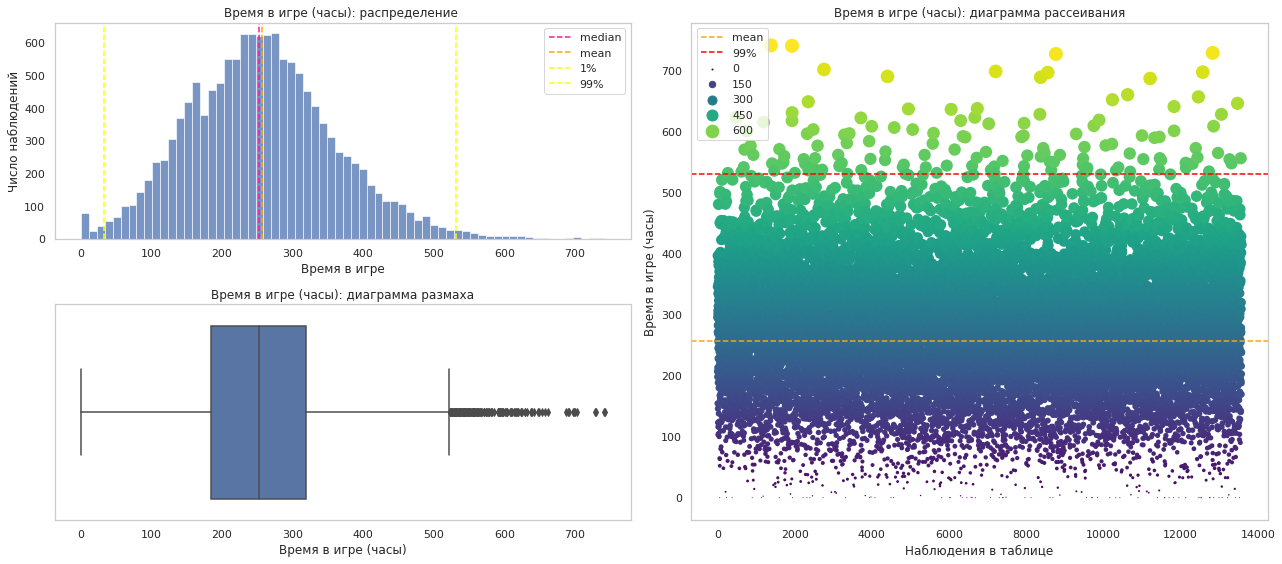

In [62]:
plotter(profiles, 'hours_in_game', 'Время в игре (часы)', 
        y_label='Число наблюдений', x_label='Время в игре')

Почти все пользователи уложились в диапазон времени от 32 до 530 часов со средним - 253 часов. Избавимся от игроков с нулем часов в игре и с длительностью более 531 часа (99-й перцентиль) и снова построим графики.

In [63]:
profiles_without_outliers = profiles.query('0 < hours_in_game < 530')
len(profiles_without_outliers)

13380

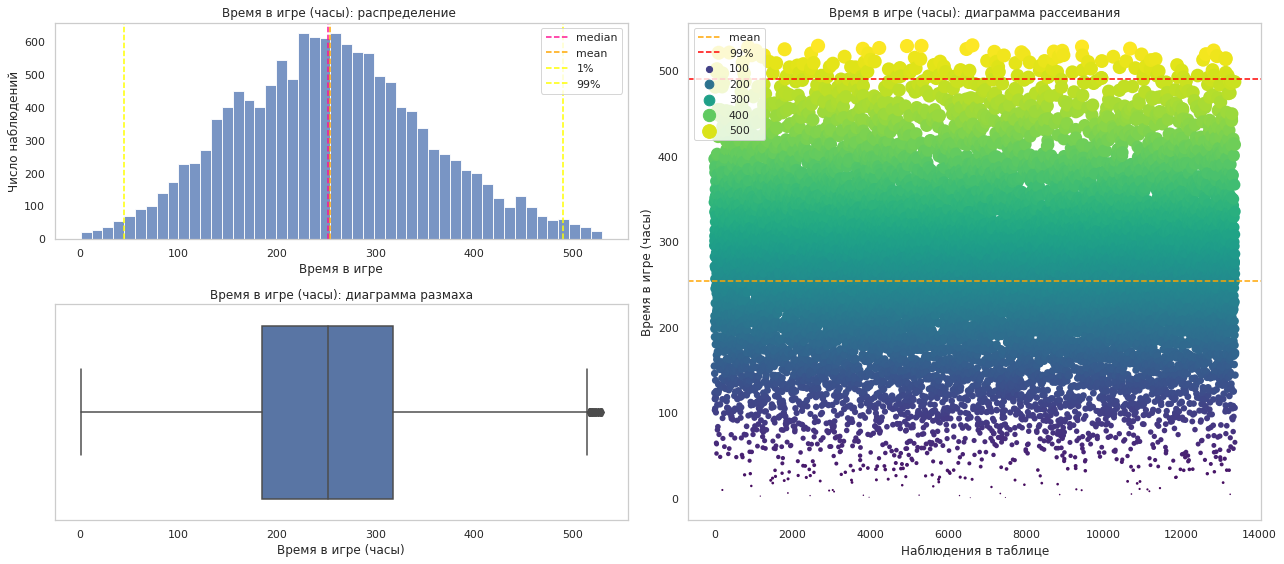

In [64]:
plotter(profiles_without_outliers, 'hours_in_game', 'Время в игре (часы)', 
        y_label='Число наблюдений', x_label='Время в игре')

&#9889; **Вывод:** 

1. В данных были выбросы, которые хорошо заметны на диаграмме рассеивания и диаграмме размаха. 
2. Выбросы не оказывали сильное влияние на среднее по отношению к медиане по причине наличия выбросов у нуля. 
3. В целом, выбросов было около одного процента, но поскольку они могли оказать влияние на статистические тесты - сократили выборку до 99-ого перцентиля.

[В оглавление](#TOC)

## 2) Проверим распределение на нормальность<a class='anchor' id='3_2'>

### - сделаем выборку только тех, кто завершил первый уровень

In [65]:
finished_first_stage = profiles_without_outliers.query('last_event == "finished_stage_1"')
finished_first_stage

,user_id,first_ts,first_building_type,last_ts,last_event,hours_in_game,project_type,num_of_builds,source,acquisition_cost
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,assembly_shop,2020-05-12 07:40:47,finished_stage_1,154.65,None,2,Instagram,0.631816
6,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,assembly_shop,2020-05-17 21:47:49,finished_stage_1,301.28,None,3,Instagram,0.631816
7,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,assembly_shop,2020-05-16 19:57:40,finished_stage_1,306.83,None,3,Facebook,0.790442
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,assembly_shop,2020-05-15 16:02:01,finished_stage_1,271.44,None,2,Я.Директ,0.466381
10,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,assembly_shop,2020-05-16 13:48:39,finished_stage_1,145.98,None,2,Instagram,0.668220
...,...,...,...,...,...,...,...,...,...,...
13568,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,2020-05-06 06:34:18,assembly_shop,2020-05-19 04:03:24,finished_stage_1,309.48,None,2,Я.Директ,0.464206
13570,ffe810f4-1a1f-464b-924d-6f120b0cb8df,2020-05-04 17:46:05,assembly_shop,2020-05-18 02:03:36,finished_stage_1,320.29,None,2,YouTube,0.396357
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,assembly_shop,2020-05-11 22:15:54,finished_stage_1,188.28,None,3,Instagram,0.649590
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04 02:05:09,assembly_shop,2020-05-12 13:01:52,finished_stage_1,202.95,None,3,Я.Директ,0.466381


&#9889; **Выводы:** в выборку попали 5740 игроков - достаточно для теста

[В оглавление](#TOC)

### - проверим статистическим методом, что выборки нормально распределены

Поскольку выборка включает более 100 наблюдений для проверки распределения на нормальность применим критерий Колмогорова-Смирнова (критерий Шапиро-Уилка неустойчив на выборках более 100 наблюдений). Зададим класс для теста.

In [66]:
class NormalityCheck:
    """Проверяем данныe на нормальность по критерию Колмогорова-Смирнова."""
    
    def __init__(self, test_params):
        self.test_params = test_params
        self.result = []
        

    def hypo_check(self, row):
        """Функция для закопления колонки сведениями о принятой или 
        отвергнутой гипотезе."""
        if row['p-value < alpha']:
            return 'Н1'
        return 'Н0'
    
    def reporter(self):
        """Формируем отчет о результатах тестирования."""
        report = pd.DataFrame(self.result.copy())
        report.columns = ['Выборка', 'Нулевая гипотеза (Н0)',
                          'Альтернативная гипотеза (Н1)', 'alpha', 'p-value']
        report['p-value < alpha'] = report['p-value'] < report['alpha']
        report['Н0/Н1'] = report.apply(self.hypo_check, axis=1)
        return report
        
    
    def kolmogorov_smirnov(self):
        """Проверка данных на нормальность. Критерий Колмогорова-Смирнова."""
        
        for sample in self.test_params:
            distribution = self.test_params[sample]['distribution']
            alpha = self.test_params[sample]['alpha']
            zero_hypothesis = self.test_params[sample]['zero_hypothesis']
            alt_hypothesis = self.test_params[sample]['alt_hypothesis']
            chain_results = kstest(distribution, 'norm')
            p_value = chain_results[1]
            
            self.result.append((sample,
                                zero_hypothesis,
                                alt_hypothesis,
                                alpha,
                                p_value))

        report = self.reporter()
        return report

Проверим верно ли визуальное наблюдение о нормальности распределений двух выборок. Для этого проверим гипотезу для каждой из выборок - полной и только с игроками, завершившим первый уровень - "выборка нормально распределена" по критерию Коломогорова-Смирнова (в виду того, что выборка достаточно большая).

1. Для полной выборки:
    - нулевую гипотезу, которую проверяет тест, сформулируем так: "Выборка нормально распределена",
    - альтернативную гипотезу, соответственно, сформулируем так: "Распределение выборки не нормально",
    - примем уровень значимости в 5%. 
<br></br>

2. Для выборки с игроками, завершивших первый уровень:
    - нулевую гипотезу, которую проверяет тест, сформулируем так: "Выборка нормально распределена",
    - альтернативную гипотезу, соответственно, сформулируем так: "Распределение выборки не нормально",
    - примем уровень значимости в 5%. 

In [67]:
test_params = {'Все игроки': {'distribution': profiles_without_outliers['hours_in_game'],
                             'alpha': 0.05,
                             'zero_hypothesis': 'Выборка игроков нормально распределена',
                             'alt_hypothesis': 'Распределение выборки игроков не нормально'},
               'Завершили первый уровень': {'distribution': finished_first_stage['hours_in_game'],
                                            'alpha': 0.05,
                                            'zero_hypothesis': 'Выборка игроков, завершивших первый уровень нормально распределена',
                                            'alt_hypothesis': 'Распределение выборки игроков, завершивших первый уровень не нормально'}}

In [68]:
report = NormalityCheck(test_params).kolmogorov_smirnov()
(report.style
       .set_properties(**{'text-align': 'left'})
       .set_table_styles([{'selector': 'th',
                           'props': [('text-align','left')]}])
       .format({'alpha': "{:.2f}", 'p-value < alpha': bool}))

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Все игроки,Выборка игроков нормально распределена,Распределение выборки игроков не нормально,0.05,0.000000,True,Н1
1,Завершили первый уровень,"Выборка игроков, завершивших первый уровень нормально распределена","Распределение выборки игроков, завершивших первый уровень не нормально",0.05,0.000000,True,Н1


&#9889; **Выводы**

1. В отношении распределения выборки со всеми игроками, исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: распределение выборки игроков не нормально.
2. В отношении распределения выборки со всеми игроками, исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: распределение выборки игроков, завершивших первый уровень не нормально.
3. Поскольку распределения не относятся к нормальному закону распределения будем проверять гипотезы непараметрическими методами.

[В оглавление](#TOC)

### 3) Проверим гипотезу о зависимости времени завершения уровня различается в зависимости от способа прохождения<a class='anchor' id='3_3'>

### - зададим класс для теста.

In [69]:
class MannWhitneyU(NormalityCheck):
    """Критерий Манна-Уитни для оценки различий между двумя выборками."""
    
    def mannwhitneyu(self):
        """Проверка данных на нормальность. Критерий Колмогорова-Смирнова."""
        for sample in self.test_params:        
            distributions = self.test_params[sample]['distribution']
            alpha = self.test_params[sample]['alpha']
            zero_hypothesis = self.test_params[sample]['zero_hypothesis']
            alt_hypothesis = self.test_params[sample]['alt_hypothesis']
            p_value = mannwhitneyu(distributions[0],
                                   distributions[1])[1]

            self.result.append((sample,
                                zero_hypothesis,
                                alt_hypothesis,
                                alpha,
                                p_value))

        report = self.reporter()
        return report

### - проверим различие во времени завершения первого этапа двух типов игроков

Ранее было установлено, что среднее время в игре у игроков с проектом больше, чем у игроков без проекта. Визуализируем различия:

In [70]:
def overlaid_histogram(data1, data2, labels=None, n_bins=0):
    """Строим соотносимые гистограммы для двух выборок"""  
    
    # если не переданы подписи
    if not labels:
        labels = {'data1_name': '',
                  'data2_name': '',
                  'xlabel': '', 
                  'ylabel': '',
                  'title': ''}
            
    # Устанавливаем границы для корзин так чтобы оба 
    # распределения на графике были соотносимы
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins


    if n_bins == 0:
        bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
    else: 
        bins = n_bins

    # рисуем графики
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(10, 8))

    plt.hist(data1, bins=bins, color='red',
            alpha=0.65, label=labels['data1_name'])
    plt.hist(data2, bins=bins, color='royalblue',
            alpha=0.65, label=labels['data2_name'])
    
    # добавляем средние  
    plt.axvline(data1.mean(), linestyle='--',
               color='lime', label=f'Среднее "{labels["data1_name"]}"')

    plt.axvline(data2.mean(), linestyle='--',
               color='coral', label=f'Среднее "{labels["data2_name"]}"')
    
    # спрячем сетку
    plt.grid(False)
    
    # спрячем лишние границы
    sns.despine(left=True, bottom=True)

    # подписываем график и оси 
    plt.xlabel(labels['xlabel'], labelpad=30)
    plt.ylabel(labels['ylabel'])
    plt.title(labels['title'], loc='left', pad=30,
              fontsize=12, fontweight='bold')
    plt.legend(loc=0)
    plt.tight_layout()


Сделаем подвыборки игроков с проектом и без проекта:

In [71]:
project = finished_first_stage.query('project_type == "satellite_orbital_assembly"')['hours_in_game']
fight = finished_first_stage.query('project_type == "None"')['hours_in_game']

Зададим подписи для графика:

In [72]:
labels = {'data1_name': 'Игроки с проектом',
          'data2_name': 'Игроки без проекта',
          'xlabel': 'Время в игре', 
          'ylabel': 'Количество игроков',
          'title': 'Игроки, завершивишие первый этап (c проектом и без)'}

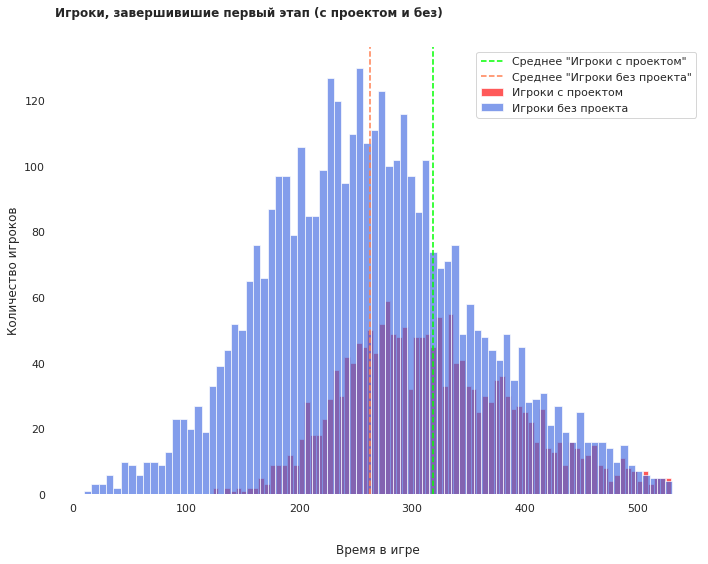

In [73]:
overlaid_histogram(project,
                   fight,
                   labels, n_bins=80)

На графике отчетливо видно, что среднее время игроков в проекте больше, чем игроков без проекта. Посмотрим как различается время завершения первого этапа у двух типов игроков в числовом выражении: 

In [74]:
mean_time_of_finishing = simple_grouper(finished_first_stage, 'project_type', agg_dict={'hours_in_game': 'mean'})
mean_time_of_finishing

,project_type,hours_in_game
0,None,262.868048
1,satellite_orbital_assembly,318.120721


&#9889; **Выводы**: разница между двумя типами игроков есть - игроки с проектом, в среднем, провели на 56 часов (чуть более двух дней) дольше игроков без проекта. 

[В оглавление](#TOC)

### - проверим гипотезу о том, что различие во времени завершения уровня через проект и через победу над первым игроком имеет статистическую значимость

Проверим гипотезу "Время завершения уровня различается в зависимости способа прохождения - через проект или через победу над игроком":
   - нулевую гипотезу, которую проверяет тест, сформулируем так: "Во времени завершения между группами нет различий",
   - альтернативную гипотезу, соответственно, сформулируем так: "Во времени завершения между группами есть различия",
   - примем уровень значимости в 5%.

Зададим параметры для теста:

In [75]:
test_params = {'Игроки с проектом и игроки без проекта': {'distribution': [project, fight],
                                                          'alpha': 0.05,
                                                          'zero_hypothesis': 'Во времени завершения между игроками нет различий',
                                                          'alt_hypothesis': 'Во времени завершения между игроками есть различия'}}

Проведем тест, получим результат:

In [76]:
report = MannWhitneyU(test_params).mannwhitneyu()
(report.style
       .set_properties(**{'text-align': 'left'})
       .set_table_styles([{'selector': 'th',
                           'props': [('text-align','left')]}])
       .format({'alpha': "{:.2f}", 'p-value < alpha': bool}))

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Игроки с проектом и игроки без проекта,Во времени завершения между игроками нет различий,Во времени завершения между игроками есть различия,0.05,0.000000,True,Н1


&#9889; **Выводы**: 

В отношении различий времени завершения первого этапа игры между игроками с проектом или игроками без проекта, исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: во времени завершения между группами игроков с проектом и без проекта есть статистически значимые различия.

[В оглавление](#TOC)

### 4) Проверим гипотезу о зависимости времени завершения уровня в зависимости от числа построек<a class='anchor' id='3_4'>

### - проверим различие во времени завершение первого этапа в зависимости от числа построек

Ранее было замечено, что число построек влияет на время в игре:

In [77]:
simple_grouper(profiles, 'num_of_builds', agg_dict={'hours_in_game': 'mean'})

,num_of_builds,hours_in_game
0,1,85.476290
1,2,206.829165
2,3,299.695845


Если в отношении времени игроков с одним зданием различие не столь существенно - менее трех процентов игроков строят только одно здание, то различие во времени игроков с двумя и тремя зданиями выглядит любопытно: дополнительная постройка существенно увеличивает время в игре. Убедимся, что в выборке с игроками, завершивших первый этап сохраняется это же соотношение, при этом, исключим пользователей с проектом, чтобы оценить чистую разницу:

In [78]:
simple_grouper(finished_first_stage.query('project_type == "None"'), 'num_of_builds', agg_dict={'hours_in_game': 'mean'})

,num_of_builds,hours_in_game
0,1,109.046140
1,2,232.804822
2,3,286.718818


Визуализируем распределение выборок:

In [79]:
two_builds = finished_first_stage.query('project_type == "None" and num_of_builds == 2')['hours_in_game']
three_builds = finished_first_stage.query('project_type == "None" and num_of_builds == 3')['hours_in_game']

Подписи для графика:

In [80]:
labels = {'data1_name': 'Игроки с двумя зданиями',
          'data2_name': 'Игроки с тремя зданиями',
          'xlabel': 'Время в игре', 
          'ylabel': 'Количество игроков',
          'title': 'Распределения игроков, завершивиших первый этап'}

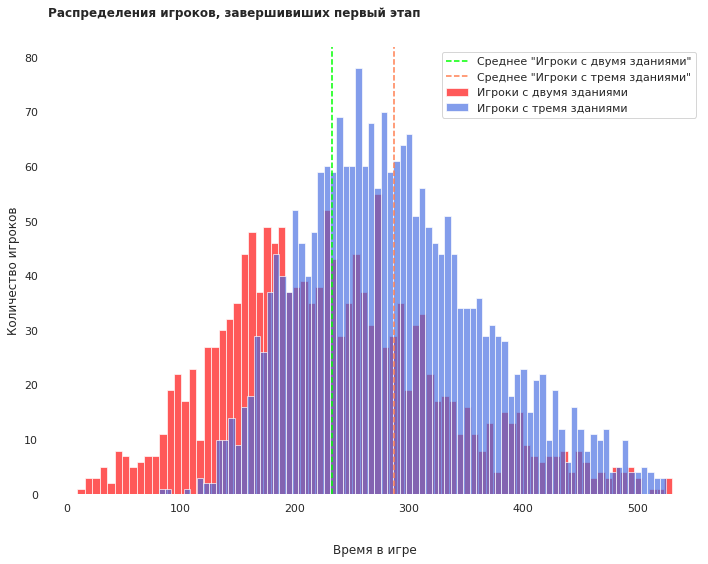

In [81]:
overlaid_histogram(two_builds,
                   three_builds,
                   labels, n_bins=80)

&#9889; **Вывод:** как было выявлено ранее, игроки завершают первый уровень независимо от количества построек - есть игроки и с одним зданием, однако из представленных данных следует, что количество построек сильно влияет на время в игре, игроки с тремя постройками потратили на завершение уровня, в среднем, на 52 часа больше (более двух суток). Визуально хорошо заметно, что средние разнесены друг от друга, значительное число игроков с двумя типами построек заказнчивают уровень раньше.



[В оглавление](#TOC)

### - проверим гипотезу о том, что различие во времени завершения уровня у игроков с двумя зданиями и тремя зданиями имеют статистическую значимость

Проверим гипотезу "Время завершения уровня различается в зависимости от количества построек - две или три":
   - нулевую гипотезу, которую проверяет тест, сформулируем так: "Во времени завершения между группами нет различий",
   - альтернативную гипотезу, соответственно, сформулируем так: "Во времени завершения между группами есть различия",
   - примем уровень значимости в 5%.

Зададим параметры для теста:

In [82]:
test_params = {'Игроки с двумя и тремя зданиями': {'distribution': [two_builds, three_builds],
                                                   'alpha': 0.05,
                                                   'zero_hypothesis': 'Во времени завершения между игроками нет различий',
                                                   'alt_hypothesis': 'Во времени завершения между игроками есть различия'}}

Проведем тест, получим результат:

In [83]:
report = MannWhitneyU(test_params).mannwhitneyu()
(report.style
       .set_properties(**{'text-align': 'left'})
       .set_table_styles([{'selector': 'th',
                           'props': [('text-align','left')]}])
       .format({'alpha': "{:.2f}", 'p-value < alpha': bool}))

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,Игроки с двумя и тремя зданиями,Во времени завершения между игроками нет различий,Во времени завершения между игроками есть различия,0.05,0.000000,True,Н1


&#9889; **Выводы**: 

В отношении различий времени завершения первого этапа игры между игроками с двумя или тремя постройками, исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: во времени завершения между группами игроков с двумя или тремя постройками есть статистически значимые различия.

[В оглавление](#TOC)

## Выводы<a class="anchor" id="3_conclusion"></a>

1. Есть статистически значимое различие, на уровне 5%, во времени завершения уровня в зависимости от способа прохождения - через победу или через проект: завершение через проект, в среднем, удлиняет время завершения 56 часов (чуть более двух дней).
2. Есть статистически значимое различие, на уровне 5%, во времени завершения уровня в зависимости от числа зданий - двух или трех зданиями: игроки с тремя постройками потратили на завершение уровня, в среднем, на 52 часа больше (более двух суток).
3. Иходя из описания задачи, предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Прдеставляется, что такой способ монетизации может быть неоптимальным:
    - завершить первый этап возможно и с одной постройкой, что существенно снижает время в игре,
    - в игре всего три постройки, и, с некоторой осторожностью, можно предположить, что постройки требуют значительного времени (сбор ресуров для постройки или само время строительства?) и, как следствие, игрок нечасто заходит на этот экран,
    - исходя из представленмных данных, принимая во внимание результаты исследования, можно сделать вывод, что игроки предпочитают меньше строить, что также может сказаться на окупаемости при выбранной модели,
4. С некоторой осторожностью, исходя из представленных данных, можно предложить альтернативный вариант монетизации - внутриигровые покупки: например ускорение строительства или покупка ресурсов для построек.
5. С некоторой осторожностью, принимая во внимание краткий период наблюдения, в отношении каналов привлечения следует отметить, что самым привлекающим является Яндекс.Директ, с разумной стоимостью привлечения. Вместе с тем, обращает на себя внимание YouTube, который получил примерно 14% от рекламного бюджета (для сравнения -  Яндекс.Директ 29.36%), Инстаграм 28.42% и Фэйсбук 28.15%), но привлек почти столько же игроков, сколько и Facebook, и не сильно отстал от трафика из Инстраграмма: возможно, стоит осторожно увеличить траты именно на этот канал. В отношении Facebook рекомендовано оценить целесообразность покупки трафика - канал привлечения выглядит сравнительно неэффективным, привлечение практически идентично YouTube (20.08% и 19.78%, соответственно), но стоимость привлечения вдвое больше (0.79 против 0.4, соответственно). Даже в отсутствие сведений о предполагаемой стоимости и типа размещения рекламы в мобильной игре - в отношении канала Facebook, исходя из представленных данных, с разумной степенью достоверности, можно предположить потенциальную убыточность.



[В оглавление](#TOC)